In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import dask.array as da

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [3]:
DATAPATH = "../../../data/DBLP/"
OUTPUTPATH = "../../../result/aminer/"

In [4]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")
test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")

In [5]:
N = test_x.shape[0]
print("データサイズ: {}, {}".format(N, N*N))

データサイズ: 2276, 5180176


In [6]:
train_x, train_y = train_x[np.triu_indices(n=N)], train_y[np.triu_indices(n=N)]
test_x, test_y = test_x[np.triu_indices(n=N)], test_y[np.triu_indices(n=N)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2591226, 23), (2591226,), (2591226, 23), (2591226,))

In [7]:
p_train, p_test = train_y, test_y
per_train = np.count_nonzero(p_train > 0) / N / N
per_test = np.count_nonzero(p_test > 0) / N / N
print("訓練データの密度: {}, テストデータの密度: {}".format(per_train, per_test))

訓練データの密度: 0.18617938849954133, テストデータの密度: 0.04532143309416514


In [8]:
train_pearsonr = [pearsonr(train_x[:,-5+i].reshape(-1), train_y.reshape(-1))[0] for i in range(5)]
test_pearsonr = [pearsonr(test_x[:,-5+i].reshape(-1), test_y.reshape(-1))[0] for i in range(5)]

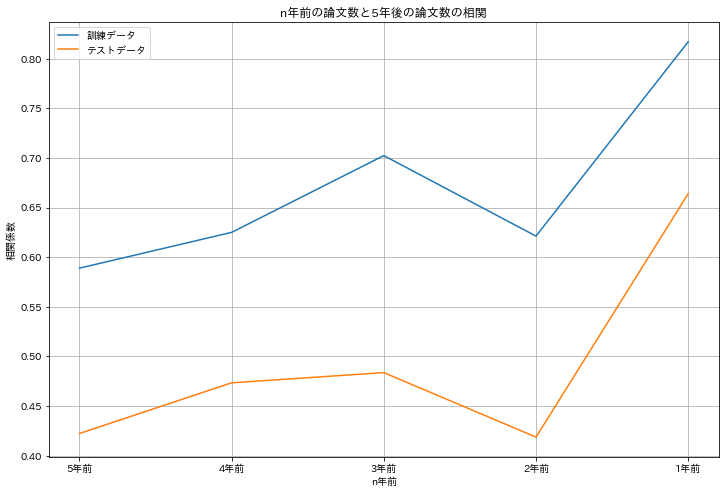

In [9]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.plot(range(1,6), train_pearsonr, label="訓練データ")
ax.plot(range(1,6), test_pearsonr, label="テストデータ")
ax.set_xticks([1,2,3,4,5]) 
ax.set_xticklabels([str(5-i) + "年前" for i in range(5)])
ax.set_xlabel("n年前")
ax.set_ylabel("相関係数")
ax.set_title("n年前の論文数と5年後の論文数の相関")
ax.grid()
ax.legend()
fig.savefig(OUTPUTPATH+"img/corr.png")
fig.show()

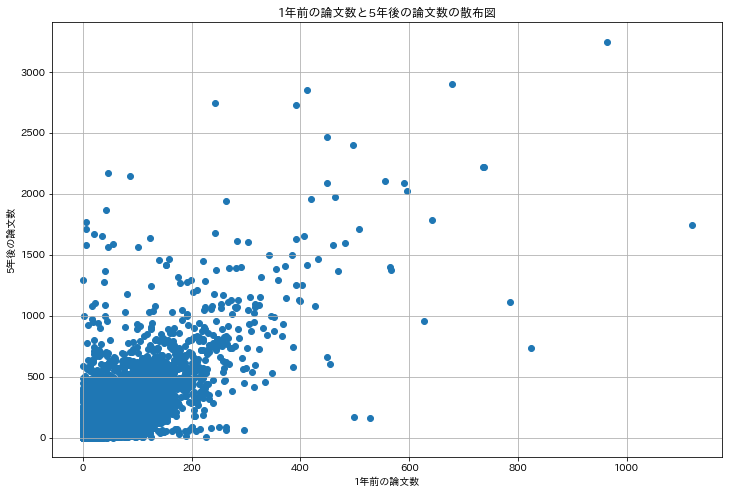

In [10]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.scatter(train_x[:,-1].reshape(-1), train_y.reshape(-1))
ax.set_xlabel("1年前の論文数")
ax.set_ylabel("5年後の論文数")
ax.set_title("1年前の論文数と5年後の論文数の散布図")
ax.grid()
# fig.savefig(OUTPUTPATH+"img/corr.png")
fig.show()

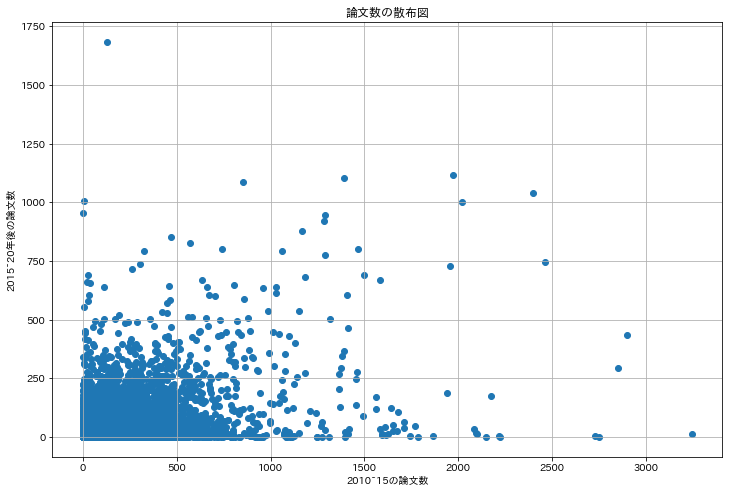

In [11]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.scatter(train_y.reshape(-1), test_y.reshape(-1))
ax.set_xlabel("2010~15の論文数")
ax.set_ylabel("2015~20年後の論文数")
ax.set_title("論文数の散布図")
ax.grid()
# fig.savefig(OUTPUTPATH+"img/corr.png")
fig.show()

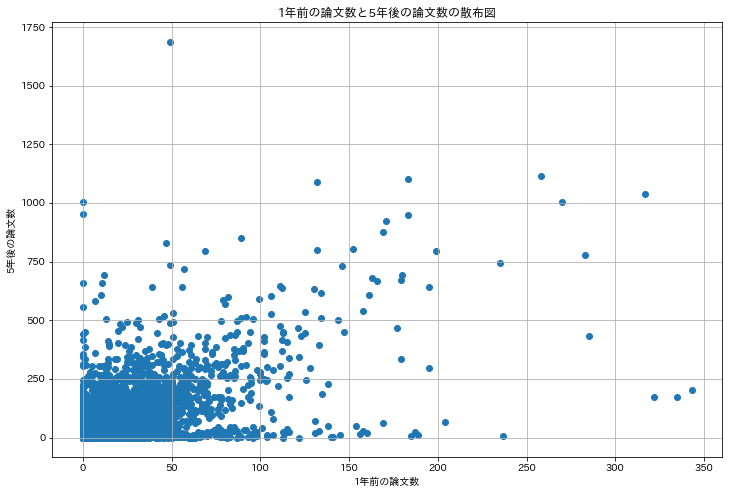

In [12]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.scatter(test_x[:,-1].reshape(-1), test_y.reshape(-1))
ax.set_xlabel("1年前の論文数")
ax.set_ylabel("5年後の論文数")
ax.set_title("1年前の論文数と5年後の論文数の散布図")
ax.grid()
# fig.savefig(OUTPUTPATH+"img/corr.png")
fig.show()